In [1]:
import datetime as dt
import numpy as np
import netCDF4 as nc
import pandas as pd
import glob
from salishsea_tools import geo_tools
import gsw
import os
import pytz
import matplotlib.pyplot as plt
import cmocean as cmo
import warnings
from sqlalchemy import create_engine, case, MetaData
from sqlalchemy.orm import create_session, aliased
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.sql import and_, or_, not_, func
from salishsea_tools import viz_tools

%matplotlib inline

In [2]:
basedir='/ocean/shared/SalishSeaCastData/DFO/CTD/'
dbname='DFO_CTD.sqlite.0'
datelims=()

In [3]:
engine = create_engine('sqlite:///' + basedir + dbname, echo = False)

In [4]:
grid = nc.Dataset('/data/eolson/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc')

In [7]:
md=MetaData()
md.reflect(engine)
Base = automap_base(metadata=md)
# reflect the tables in salish.sqlite:
Base.prepare()
# mapped classes have been created
# existing tables:
StationTBL=Base.classes.StationTBL
ObsTBL=Base.classes.ObsTBL
CalcsTBL=Base.classes.CalcsTBL
#AncTBL=Base.classes.AncillaryTBL
#JDFLocsTBL=Base.classes.JDFLocsTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)

In [8]:
qry=session.query(ObsTBL.Depth,CalcsTBL.Z,ObsTBL.Salinity,ObsTBL.Salinity_T0_C0,ObsTBL.Salinity_T1_C1,CalcsTBL.Salinity_SA,CalcsTBL.Salinity_T0_C0_SA,CalcsTBL.Salinity_T1_C1_SA,
                  CalcsTBL.Temperature_CT,CalcsTBL.Temperature_Primary_CT,CalcsTBL.Temperature_Secondary_CT).\
    select_from(CalcsTBL).join(ObsTBL,ObsTBL.ID==CalcsTBL.ObsTBLID).filter(ObsTBL.Depth==ObsTBL.Depth).all()

In [9]:
df=pd.DataFrame(qry)

In [10]:
df.describe()

,Depth,Z,Salinity,Salinity_T0_C0,Salinity_T1_C1,Salinity_SA,Salinity_T0_C0_SA,Salinity_T1_C1_SA,Temperature_CT,Temperature_Primary_CT,Temperature_Secondary_CT
count,625792.000000,625792.000000,31937.000000,436408.000000,156759.000000,31937.000000,436408.000000,156759.000000,31937.000000,436407.000000,156759.000000
mean,458.971048,458.936493,20.731693,31.987268,32.920598,20.831751,32.147733,33.087825,10.267989,7.365447,6.086058
std,561.847770,561.867709,10.530876,2.173482,1.966719,10.581674,2.189527,1.981861,2.544349,3.073711,2.848735
min,0.100000,0.099145,0.030000,3.692200,12.503000,0.030145,3.710085,12.563543,2.341295,1.414291,1.412261
25%,70.200000,70.185336,19.870000,30.378700,31.081050,19.966238,30.526748,31.235731,7.756828,4.388278,3.483690
50%,204.100000,204.046142,26.320000,31.373950,33.986900,26.447329,31.529313,34.156197,10.451759,8.579043,5.807047
75%,685.000000,685.033546,27.630000,34.161900,34.363000,27.762706,34.338418,34.544961,11.683578,9.599887,8.713736
max,3224.700000,3224.797861,31.490000,34.649300,34.649100,31.642130,34.838263,34.838142,22.364380,20.877578,19.108750


In [11]:
np.min((df['Depth']-df['Z'])/df['Z']),np.max((df['Depth']-df['Z'])/df['Z'])

(-0.3276455137262745, 0.15999656634004117)

In [12]:
df.loc[np.abs((df['Depth']-df['Z'])/df['Z'])>.1]

,Depth,Z,Salinity,Salinity_T0_C0,Salinity_T1_C1,Salinity_SA,Salinity_T0_C0_SA,Salinity_T1_C1_SA,Temperature_CT,Temperature_Primary_CT,Temperature_Secondary_CT
26905,2.3,1.982764,NaN,29.3926,NaN,NaN,29.534709,NaN,NaN,11.387468,NaN
29134,2.2,1.982731,NaN,30.9675,NaN,NaN,31.116464,NaN,NaN,10.039943,NaN
41354,0.4,0.495745,NaN,23.2041,NaN,NaN,23.316721,NaN,NaN,15.528922,NaN
43579,0.8,0.892337,NaN,24.6111,NaN,NaN,24.730547,NaN,NaN,16.575219,NaN
74005,0.4,0.495760,NaN,32.5574,NaN,NaN,32.712540,NaN,NaN,7.454501,NaN
304172,0.2,0.297462,NaN,28.4599,NaN,NaN,28.597668,NaN,NaN,9.945137,NaN
324947,0.8,0.892259,NaN,28.5844,NaN,NaN,28.722690,NaN,NaN,11.301725,NaN
558022,1.2,1.090715,NaN,31.6466,NaN,NaN,31.799106,NaN,NaN,11.011486,NaN
624025,0.7,0.793203,NaN,27.1683,NaN,NaN,27.299995,NaN,NaN,7.357459,NaN


In [13]:
df.head(10)

,Depth,Z,Salinity,Salinity_T0_C0,Salinity_T1_C1,Salinity_SA,Salinity_T0_C0_SA,Salinity_T1_C1_SA,Temperature_CT,Temperature_Primary_CT,Temperature_Secondary_CT
0,0.15,0.148733,28.50,NaN,NaN,28.637903,NaN,NaN,19.043626,NaN,NaN
1,0.45,0.446197,28.56,NaN,NaN,28.698180,NaN,NaN,18.148806,NaN,NaN
2,0.75,0.743662,28.23,NaN,NaN,28.366569,NaN,NaN,17.770452,NaN,NaN
3,1.05,1.041125,28.26,NaN,NaN,28.396701,NaN,NaN,17.462734,NaN,NaN
4,1.35,1.338589,28.41,NaN,NaN,28.547413,NaN,NaN,17.003485,NaN,NaN
5,1.65,1.636052,28.17,NaN,NaN,28.306239,NaN,NaN,16.479931,NaN,NaN
6,1.95,1.933514,28.00,NaN,NaN,28.135403,NaN,NaN,16.142068,NaN,NaN
7,2.25,2.230977,28.01,NaN,NaN,28.145438,NaN,NaN,15.783394,NaN,NaN
8,2.55,2.528438,28.12,NaN,NaN,28.255957,NaN,NaN,15.488895,NaN,NaN
9,2.85,2.825899,28.13,NaN,NaN,28.265992,NaN,NaN,15.347303,NaN,NaN


In [14]:
sorted([x.name for x in md.tables['StationTBL'].columns])

['AGENCY',
 'COUNTRY',
 'DATA_DESCRIPTION',
 'EVENT_NUMBER',
 'ID',
 'Include',
 'LATITUDE',
 'LONGITUDE',
 'Lat',
 'Lon',
 'MISSION',
 'MODEL',
 'PLATFORM',
 'PROJECT',
 'SCIENTIST',
 'START_TIME',
 'STATION',
 'StartDay',
 'StartHour',
 'StartMonth',
 'StartTimeZone',
 'StartYear',
 'TYPE',
 'WATER_DEPTH',
 'WDIR',
 'WSPD',
 'sourceFile']

In [15]:
sorted([x.name for x in md.tables['ObsTBL'].columns])


['Conductance_Specific',
 'Conductance_Specific_units',
 'Conductivity',
 'Conductivity_Primary',
 'Conductivity_Primary_units',
 'Conductivity_Secondary',
 'Conductivity_Secondary_units',
 'Conductivity_units',
 'Density',
 'Density_units',
 'Depth',
 'Depth_units',
 'Fluorescence_URU_Seapoint',
 'Fluorescence_URU_Seapoint_units',
 'Fluorescence_URU_Wetlabs',
 'Fluorescence_URU_Wetlabs_units',
 'ID',
 'Include',
 'Number_of_bin_records',
 'Number_of_bin_records_units',
 'Oxygen_Dissolved_SBE',
 'Oxygen_Dissolved_SBE_1',
 'Oxygen_Dissolved_SBE_1_units',
 'Oxygen_Dissolved_SBE_units',
 'PAR',
 'PAR1',
 'PAR1_units',
 'PAR_1',
 'PAR_1_units',
 'PAR_Reference',
 'PAR_Reference_units',
 'PAR_units',
 'Pressure',
 'Pressure_units',
 'Salinity',
 'Salinity_T0_C0',
 'Salinity_T0_C0_units',
 'Salinity_T1_C1',
 'Salinity_T1_C1_units',
 'Salinity_units',
 'Speed_Sound',
 'Speed_Sound_units',
 'StationTBLID',
 'Temperature',
 'Temperature_Primary',
 'Temperature_Primary_units',
 'Temperature_Seco

In [16]:
sorted([x.name for x in md.tables['CalcsTBL'].columns])


['Include',
 'ObsTBLID',
 'Salinity_SA',
 'Salinity_T0_C0_SA',
 'Salinity_T1_C1_SA',
 'StationTBLID',
 'Temperature_CT',
 'Temperature_Primary_CT',
 'Temperature_Secondary_CT',
 'Z']

#### salinity variables: 'Salinity','Salinity_T0_C0', 'Salinity_T1_C1'
#### temperature variables:'Temperature','Temperature_Primary','Temperature_Secondary'

### How many Depths with no Pressure and vice versa?

In [17]:
print('Z without P:',session.query(ObsTBL.Depth).filter(ObsTBL.Pressure==None).count())
print('P without Z:',session.query(ObsTBL.Pressure).filter(ObsTBL.Depth==None).count())


Z without P: 0
P without Z: 1010164


### Other depth info:

In [18]:
print('Z min, max:',session.query(func.min(ObsTBL.Depth)).one(),session.query(func.max(ObsTBL.Depth)).one())
print('P min, max:',session.query(func.min(ObsTBL.Pressure)).one(),session.query(func.max(ObsTBL.Pressure)).one())

Z min, max: (0.1,) (3224.7,)
P min, max: (0.0,) (3278.8,)


### Other Variables:

In [19]:
for var in (ObsTBL.Salinity,ObsTBL.Salinity_T0_C0,ObsTBL.Salinity_T1_C1,ObsTBL.Temperature,ObsTBL.Temperature_Primary,ObsTBL.Temperature_Secondary):
    print(var,'min max count:',session.query(func.min(var)).one(),session.query(func.max(var)).one(),session.query(var).filter(var!=None).count())

ObsTBL.Salinity min max count: (0.03,) (31.49,) 31937
ObsTBL.Salinity_T0_C0 min max count: (1.361,) (34.6505,) 896592
ObsTBL.Salinity_T1_C1 min max count: (3.5259,) (34.6514,) 705170
ObsTBL.Temperature min max count: (2.216,) (22.053,) 31937
ObsTBL.Temperature_Primary min max count: (1.6359,) (21.6947,) 896866
ObsTBL.Temperature_Secondary min max count: (1.6371,) (20.245,) 705261


In [20]:
vlist=(ObsTBL.Salinity,ObsTBL.Salinity_T0_C0,ObsTBL.Salinity_T1_C1,ObsTBL.Temperature,ObsTBL.Temperature_Primary,ObsTBL.Temperature_Secondary)
ulist=(ObsTBL.Salinity_units,ObsTBL.Salinity_T0_C0_units,ObsTBL.Salinity_T1_C1_units,ObsTBL.Temperature_units,
      ObsTBL.Temperature_Primary_units,ObsTBL.Temperature_Secondary_units)

In [21]:
for vvar,uvar in zip(vlist,ulist):
    print(uvar,'unique:')
    print('\t',[i for i in session.query(uvar).group_by(uvar).all()])
    print('\t','# missing units:',session.query(vvar,uvar).filter(and_(vvar!=None,uvar==None)).count())

ObsTBL.Salinity_units unique:
	 [(None,), ('PSS-78',)]
	 # missing units: 0
ObsTBL.Salinity_T0_C0_units unique:
	 [(None,), ('PSS-78',)]
	 # missing units: 0
ObsTBL.Salinity_T1_C1_units unique:
	 [(None,), ('PSS-78',)]
	 # missing units: 0
ObsTBL.Temperature_units unique:
	 [(None,), ("'deg_C_(ITS90)'",)]
	 # missing units: 0
ObsTBL.Temperature_Primary_units unique:
	 [(None,), ("'deg_C_(ITS90)'",)]
	 # missing units: 0
ObsTBL.Temperature_Secondary_units unique:
	 [(None,), ("'deg_C_(ITS90)'",)]
	 # missing units: 0


In [22]:
df=pd.DataFrame(session.query(ObsTBL.Depth,ObsTBL.Pressure,ObsTBL.Salinity,ObsTBL.Salinity_T0_C0,ObsTBL.Salinity_T1_C1,
                              ObsTBL.Temperature,ObsTBL.Temperature_Primary,ObsTBL.Temperature_Secondary,
                              StationTBL.Lat,StationTBL.Lon).select_from(ObsTBL).join(StationTBL,StationTBL.ID==ObsTBL.StationTBLID).all())

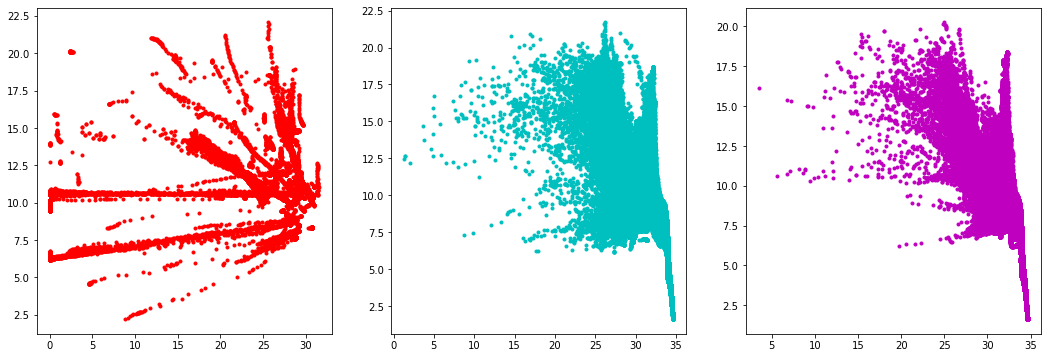

In [23]:
fig,ax=plt.subplots(1,3,figsize=(18,6))
ax[0].plot(df['Salinity'],df['Temperature'],'r.')
ax[1].plot(df['Salinity_T0_C0'],df['Temperature_Primary'],'c.')
ax[2].plot(df['Salinity_T1_C1'],df['Temperature_Secondary'],'m.')

/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/viz_tools.py:123: UserWarning: No contour levels were found within the data range.
  contour_lines = axes.contour(


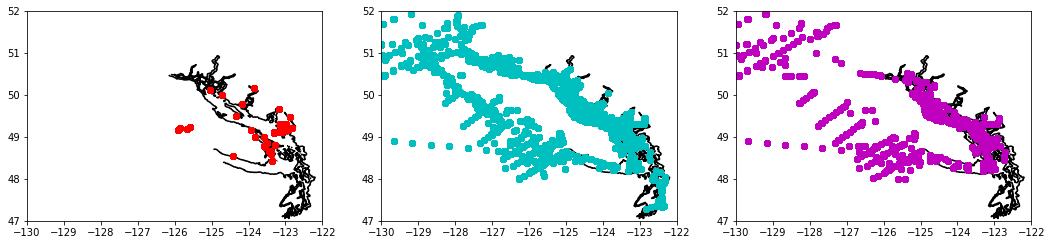

In [24]:
fig,ax=plt.subplots(1,3,figsize=(18,6))
for iax in ax:
    viz_tools.set_aspect(iax, coords = 'map')
    viz_tools.plot_coastline(iax, grid, coords = 'map')
    iax.set_ylim(47, 52)
    iax.set_xlim(-130, -122);
ax[0].plot(df.loc[(df['Salinity']>0)&(df['Temperature']>0),['Lon']],
                    df.loc[(df['Salinity']>0)&(df['Temperature']>0),['Lat']],'ro')
ax[1].plot(df.loc[(df['Salinity_T0_C0']>0)&(df['Temperature_Primary']>0),['Lon']],
                    df.loc[(df['Salinity_T0_C0']>0)&(df['Temperature_Primary']>0),['Lat']],'co')
ax[2].plot(df.loc[(df['Salinity_T1_C1']>0)&(df['Temperature_Secondary']>0),['Lon']],
                    df.loc[(df['Salinity_T1_C1']>0)&(df['Temperature_Secondary']>0),['Lat']],'mo')

In [25]:
df.loc[(~np.isnan(df['Salinity_T1_C1']))&(~np.isnan(df['Temperature_Primary']))]

,Depth,Pressure,Salinity,Salinity_T0_C0,Salinity_T1_C1,Temperature,Temperature_Primary,Temperature_Secondary,Lat,Lon


In [26]:
df.loc[(~np.isnan(df['Salinity_T1_C1']))&(~np.isnan(df['Temperature']))]

,Depth,Pressure,Salinity,Salinity_T0_C0,Salinity_T1_C1,Temperature,Temperature_Primary,Temperature_Secondary,Lat,Lon


In [27]:
df.loc[(~np.isnan(df['Salinity_T0_C0']))&(~np.isnan(df['Temperature']))]

,Depth,Pressure,Salinity,Salinity_T0_C0,Salinity_T1_C1,Temperature,Temperature_Primary,Temperature_Secondary,Lat,Lon


In [28]:
df.loc[(~np.isnan(df['Salinity_T0_C0']))&(~np.isnan(df['Temperature_Secondary']))]

,Depth,Pressure,Salinity,Salinity_T0_C0,Salinity_T1_C1,Temperature,Temperature_Primary,Temperature_Secondary,Lat,Lon


In [29]:
df.loc[(~np.isnan(df['Salinity']))&(~np.isnan(df['Temperature_Secondary']))]

,Depth,Pressure,Salinity,Salinity_T0_C0,Salinity_T1_C1,Temperature,Temperature_Primary,Temperature_Secondary,Lat,Lon


In [30]:
df.loc[(~np.isnan(df['Salinity']))&(~np.isnan(df['Temperature_Primary']))]

,Depth,Pressure,Salinity,Salinity_T0_C0,Salinity_T1_C1,Temperature,Temperature_Primary,Temperature_Secondary,Lat,Lon


In [31]:
len(df.loc[(~np.isnan(df['Salinity']))&(~np.isnan(df['Temperature']))])

31937

In [32]:
len(df.loc[(~np.isnan(df['Salinity_T0_C0']))&(~np.isnan(df['Temperature_Primary']))])

896591

In [33]:
len(df.loc[(~np.isnan(df['Salinity_T1_C1']))&(~np.isnan(df['Temperature_Secondary']))])

705170

In [34]:
qry=session.query(StationTBL.StartYear.label('Year'),StationTBL.StartMonth.label('Month'),
                      StationTBL.StartDay.label('Day'),StationTBL.StartHour.label('Hour'),
                      StationTBL.Lat,StationTBL.Lon,
                     ObsTBL.Depth,ObsTBL.Pressure,ObsTBL.Salinity,
                  ObsTBL.Salinity_T0_C0,ObsTBL.Salinity_T1_C1,
                    ObsTBL.Temperature,ObsTBL.Temperature_Primary,ObsTBL.Temperature_Secondary,ObsTBL.sourceFile).\
                select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\
                filter(and_(StationTBL.Lat>47-3/2.5*(StationTBL.Lon+123.5),
                            StationTBL.Lat<47-3/2.5*(StationTBL.Lon+121)))

In [35]:
df=pd.DataFrame(qry.all())

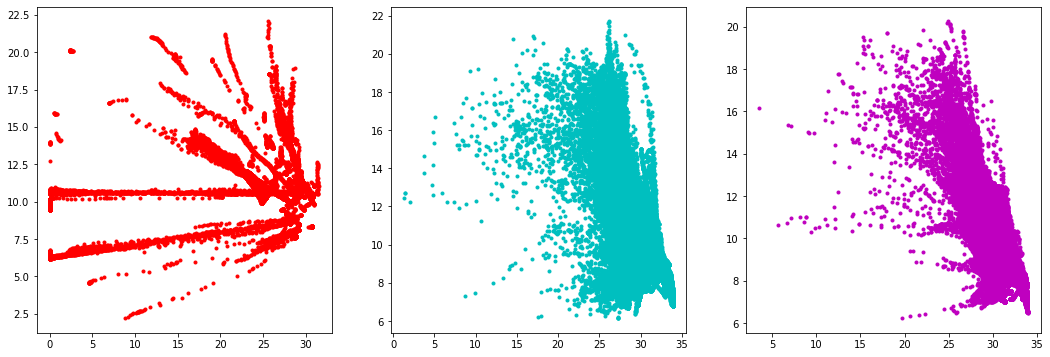

In [36]:
fig,ax=plt.subplots(1,3,figsize=(18,6))
ax[0].plot(df['Salinity'],df['Temperature'],'r.')
ax[1].plot(df['Salinity_T0_C0'],df['Temperature_Primary'],'c.')
ax[2].plot(df['Salinity_T1_C1'],df['Temperature_Secondary'],'m.')

/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/viz_tools.py:123: UserWarning: No contour levels were found within the data range.
  contour_lines = axes.contour(


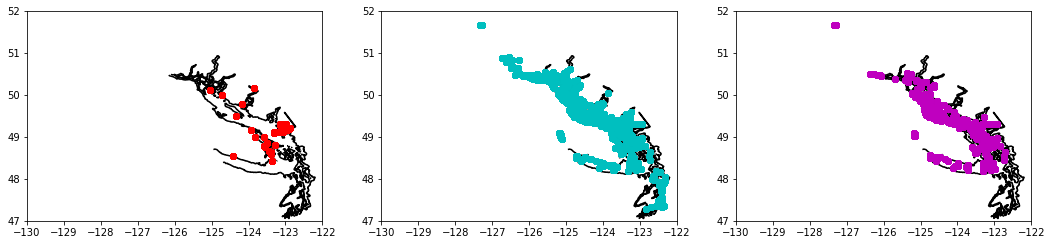

In [37]:
fig,ax=plt.subplots(1,3,figsize=(18,6))
for iax in ax:
    viz_tools.set_aspect(iax, coords = 'map')
    viz_tools.plot_coastline(iax, grid, coords = 'map')
    #iax.set_ylim(48, 50.5)
    #iax.set_xlim(-125.7, -122.5);
    iax.set_ylim(47, 52)
    iax.set_xlim(-130, -122);
ax[0].plot(df.loc[(df['Salinity']>0)&(df['Temperature']>0),['Lon']],
                    df.loc[(df['Salinity']>0)&(df['Temperature']>0),['Lat']],'ro')
ax[1].plot(df.loc[(df['Salinity_T0_C0']>0)&(df['Temperature_Primary']>0),['Lon']],
                    df.loc[(df['Salinity_T0_C0']>0)&(df['Temperature_Primary']>0),['Lat']],'co')
ax[2].plot(df.loc[(df['Salinity_T1_C1']>0)&(df['Temperature_Secondary']>0),['Lon']],
                    df.loc[(df['Salinity_T1_C1']>0)&(df['Temperature_Secondary']>0),['Lat']],'mo')

/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/viz_tools.py:123: UserWarning: No contour levels were found within the data range.
  contour_lines = axes.contour(


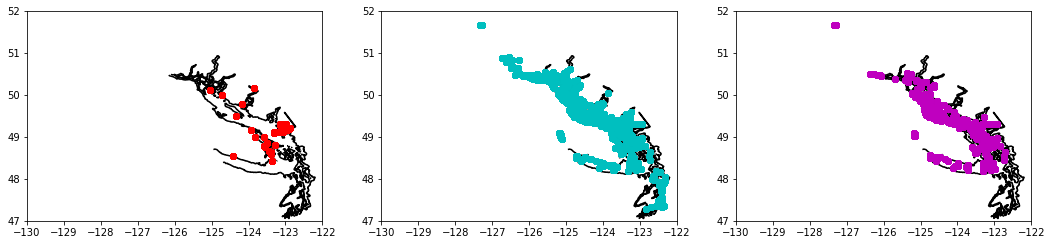

In [38]:
fig,ax=plt.subplots(1,3,figsize=(18,6))
for iax in ax:
    viz_tools.set_aspect(iax, coords = 'map')
    viz_tools.plot_coastline(iax, grid, coords = 'map')
    #iax.set_ylim(48, 50.5)
    #iax.set_xlim(-125.7, -122.5);
    iax.set_ylim(47, 52)
    iax.set_xlim(-130, -122);
ax[0].plot(df.loc[(df['Salinity']>0)&(df['Temperature']>0),['Lon']],
                    df.loc[(df['Salinity']>0)&(df['Temperature']>0),['Lat']],'ro')
ax[1].plot(df.loc[(df['Salinity_T0_C0']>0)&(df['Temperature_Primary']>0),['Lon']],
                    df.loc[(df['Salinity_T0_C0']>0)&(df['Temperature_Primary']>0),['Lat']],'co')
ax[2].plot(df.loc[(df['Salinity_T1_C1']>0)&(df['Temperature_Secondary']>0),['Lon']],
                    df.loc[(df['Salinity_T1_C1']>0)&(df['Temperature_Secondary']>0),['Lat']],'mo')

In [39]:
models=session.query(AncTBL.MODEL).distinct().all()

NameError: name 'AncTBL' is not defined

In [ ]:
models

In [ ]:
## Where are CastAway stations?
qry=session.query(StationTBL.StartYear.label('Year'),StationTBL.StartMonth.label('Month'),
                      StationTBL.StartDay.label('Day'),StationTBL.StartHour.label('Hour'),
                      StationTBL.Lat,StationTBL.Lon,
                     ObsTBL.Depth,ObsTBL.Pressure,ObsTBL.Salinity,
                  ObsTBL.Salinity_T0_C0,ObsTBL.Salinity_T1_C1,
                    ObsTBL.Temperature,ObsTBL.Temperature_Primary,ObsTBL.Temperature_Secondary,ObsTBL.sourceFile).\
                select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\
                join(AncTBL,AncTBL.StationTBLID==StationTBL.ID).\
                filter(AncTBL.MODEL=='CastAway')
fig,ax=plt.subplots(1,3,figsize=(18,6))
for iax in ax:
    viz_tools.set_aspect(iax, coords = 'map')
    viz_tools.plot_coastline(iax, grid, coords = 'map')
    #iax.set_ylim(48, 50.5)
    #iax.set_xlim(-125.7, -122.5);
    iax.set_ylim(47, 52)
    iax.set_xlim(-130, -122);
ax[0].plot(df.loc[(df['Salinity']>0)&(df['Temperature']>0),['Lon']],
                    df.loc[(df['Salinity']>0)&(df['Temperature']>0),['Lat']],'ro')
ax[1].plot(df.loc[(df['Salinity_T0_C0']>0)&(df['Temperature_Primary']>0),['Lon']],
                    df.loc[(df['Salinity_T0_C0']>0)&(df['Temperature_Primary']>0),['Lat']],'co')
ax[2].plot(df.loc[(df['Salinity_T1_C1']>0)&(df['Temperature_Secondary']>0),['Lon']],
                    df.loc[(df['Salinity_T1_C1']>0)&(df['Temperature_Secondary']>0),['Lat']],'mo')

In [ ]:
## Check CastAway profiles are excluded:
qry=session.query(StationTBL.Include).select_from(StationTBL).join(AncTBL,AncTBL.StationTBLID==StationTBL.ID).\
    filter(AncTBL.MODEL=='CastAway').distinct().all()
print('Station Include:',qry)

In [ ]:
qry=session.query(ObsTBL.Include).select_from(ObsTBL).join(AncTBL,AncTBL.StationTBLID==ObsTBL.StationTBLID).\
    filter(AncTBL.MODEL=='CastAway').distinct().all()
print('Obs Include:',qry)

In [ ]:
test=session.query(AncTBL.StationTBLID).filter(AncTBL.MODEL=='CastAway').limit(5).all()
test

In [ ]:
pd.set_option('display.max_colwidth', -1)

In [ ]:
df=pd.DataFrame(session.query(ObsTBL.StationTBLID,ObsTBL.Pressure,ObsTBL.sourceFile).filter(ObsTBL.StationTBLID==2220).limit(5))

In [ ]:
df

In [ ]:
test=session.query(ObsTBL.StationTBLID).distinct().order_by(ObsTBL.StationTBLID).all()

In [ ]:
plt.plot(test)

In [ ]:
df=pd.DataFrame(session.query(StationTBL.sourceFile).filter(StationTBL.ID==2220).all())

In [ ]:
df

In [ ]:
qry=session.query(StationTBL.StartYear.label('Year'),StationTBL.StartMonth.label('Month'),
                      StationTBL.StartDay.label('Day'),StationTBL.StartHour.label('Hour'),
                      StationTBL.Lat,StationTBL.Lon,
                     ObsTBL.Depth,ObsTBL.Pressure,ObsTBL.Salinity,
                  ObsTBL.Salinity_T0_C0,ObsTBL.Salinity_T1_C1,
                    ObsTBL.Temperature,ObsTBL.Temperature_Primary,ObsTBL.Temperature_Secondary,ObsTBL.sourceFile).\
                select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\
                join(AncTBL,AncTBL.StationTBLID==StationTBL.ID).\
                filter(and_(StationTBL.Lat>47-3/2.5*(StationTBL.Lon+123.5),
                            StationTBL.Lat<47-3/2.5*(StationTBL.Lon+121),AncTBL.MODEL!='CastAway'))
df=pd.DataFrame(qry.all())
fig,ax=plt.subplots(1,3,figsize=(18,6))
ax[0].plot(df['Salinity'],df['Temperature'],'r.')
ax[1].plot(df['Salinity_T0_C0'],df['Temperature_Primary'],'c.')
ax[2].plot(df['Salinity_T1_C1'],df['Temperature_Secondary'],'m.')

In [ ]:
qry=session.query(StationTBL.StartYear.label('Year'),StationTBL.StartMonth.label('Month'),
                      StationTBL.StartDay.label('Day'),StationTBL.StartHour.label('Hour'),
                      StationTBL.Lat,StationTBL.Lon,
                     ObsTBL.Depth,ObsTBL.Pressure,ObsTBL.Salinity,
                  ObsTBL.Salinity_T0_C0,ObsTBL.Salinity_T1_C1,
                    ObsTBL.Temperature,ObsTBL.Temperature_Primary,ObsTBL.Temperature_Secondary,ObsTBL.sourceFile).\
                select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\
                filter(and_(StationTBL.Lat>47-3/2.5*(StationTBL.Lon+123.5),
                            StationTBL.Lat<47-3/2.5*(StationTBL.Lon+121),StationTBL.Include==True))
df=pd.DataFrame(qry.all())
fig,ax=plt.subplots(1,3,figsize=(18,6))
ax[0].plot(df['Salinity'],df['Temperature'],'r.')
ax[1].plot(df['Salinity_T0_C0'],df['Temperature_Primary'],'c.')
ax[2].plot(df['Salinity_T1_C1'],df['Temperature_Secondary'],'m.')

In [ ]:
# search for duplicate stations and investigate:
a1=aliased(StationTBL)
a2=aliased(StationTBL)
dupsQRY=session.query(a1.ID.label('ID1'),a1.Include,a2.ID.label('ID2'),a2.Include,a1.sourceFile.label('source1'),a2.sourceFile.label('source2'),
                      a1.AGENCY.label('AGENCY1'),a2.AGENCY.label('AGENCY2'),a1.MODEL.label('MODEL1'),a2.MODEL.label('MODEL2'),
                     a1.EVENT_NUMBER.label('EVENT_NUMBER1'),a2.EVENT_NUMBER.label('EVENT_NUMBER2'),
                     a1.PLATFORM.label('PLATFORM1'),a2.PLATFORM.label('PLATFORM2'),
                     a1.STATION.label('STATION1'),a2.STATION.label('STATION2'),
                     a1.WATER_DEPTH.label('WATER_DEPTH1'),a2.WATER_DEPTH.label('WATER_DEPTH2')).select_from(a1).join(a2,and_(
    a1.StartYear==a2.StartYear,
    a1.StartMonth==a2.StartMonth,
    a1.StartDay==a2.StartDay,
    a1.StartHour-a2.StartHour<0.001,
    a1.StartHour-a2.StartHour>-0.001,
    a1.Lat-a2.Lat<0.001,
    a1.Lat-a2.Lat>-0.001,
    a1.Lon-a2.Lon<0.001,
    a1.Lon-a2.Lon>-0.001,
    a1.ID!=a2.ID)).filter(a1.Include==True,a2.Include==True,a1.ID<a2.ID)
# columns below were identical for each pair:
#                     a1.DATA_DESCRIPTION.label('DATA_DESCRIPTION1'),a2.DATA_DESCRIPTION.label('DATA_DESCRIPTION2'),
#                     a1.SCIENTIST.label('SCIENTIST1'),a2.SCIENTIST.label('SCIENTIST2'),
#                      a1.COUNTRY.label('COUNTRY1'),a2.COUNTRY.label('COUNTRY2'),
#                     a1.MISSION.label('MISSION1'),a2.MISSION.label('MISSION2'),
#                     a1.PROJECT.label('PROJECT1'),a2.PROJECT.label('PROJECT2'),
#                     a1.WSPD.label('WSPD1'),a2.WSPD.label('WSPD2')

In [ ]:
# search for duplicate stations and investigate:
a1=aliased(StationTBL)
a2=aliased(StationTBL)
dupsQRY=session.query(a1.ID.label('ID1'),a1.Include,a2.ID.label('ID2'),a2.Include,a1.sourceFile.label('source1'),
                      a2.sourceFile.label('source2'),
                     a1.EVENT_NUMBER.label('EVENT_NUMBER1'),a2.EVENT_NUMBER.label('EVENT_NUMBER2'),
                     a1.PLATFORM.label('PLATFORM1'),a2.PLATFORM.label('PLATFORM2'),
                     a1.STATION.label('STATION1'),a2.STATION.label('STATION2'),
                     a1.WATER_DEPTH.label('WATER_DEPTH1'),a2.WATER_DEPTH.label('WATER_DEPTH2')).\
            select_from(a1).join(a2,and_(
    a1.StartYear==a2.StartYear,
    a1.StartMonth==a2.StartMonth,
    a1.StartDay==a2.StartDay,
    a1.StartHour-a2.StartHour<0.001,
    a1.StartHour-a2.StartHour>-0.001,
    a1.Lat-a2.Lat<0.001,
    a1.Lat-a2.Lat>-0.001,
    a1.Lon-a2.Lon<0.001,
    a1.Lon-a2.Lon>-0.001,
    a1.ID!=a2.ID)).filter(a1.Include==True,a2.Include==True,a1.ID<a2.ID)
# columns below were identical for each pair:
#                     a1.DATA_DESCRIPTION.label('DATA_DESCRIPTION1'),a2.DATA_DESCRIPTION.label('DATA_DESCRIPTION2'),
#                     a1.SCIENTIST.label('SCIENTIST1'),a2.SCIENTIST.label('SCIENTIST2'),
#                      a1.COUNTRY.label('COUNTRY1'),a2.COUNTRY.label('COUNTRY2'),
#                     a1.MISSION.label('MISSION1'),a2.MISSION.label('MISSION2'),
#                     a1.PROJECT.label('PROJECT1'),a2.PROJECT.label('PROJECT2'),
#                     a1.WSPD.label('WSPD1'),a2.WSPD.label('WSPD2')

In [ ]:
dfa=pd.DataFrame(dupsQRY.all())

In [ ]:
dfa

In [ ]:
pd.set_option('display.max_colwidth', -1)

In [ ]:
pd.set_option('display.max_rows', 200)

In [ ]:
dfa[['source1','source2']]

In [ ]:
dfa['sourceA1']=[i[-45:] for i in dfa['source1']]
dfa['sourceA2']=[i[-45:] for i in dfa['source2']]

In [ ]:
len(dfa)

In [ ]:
dfa

In [ ]:
for i,r in dfa.iterrows():
    print(r['source1'],r['source2'])

In [ ]:
# in case of duplicates, take only one profile entry at each depth
a1=aliased(StationTBL)
a2=aliased(StationTBL)
dupsQRY=session.query(a1.ID.label('ID1'),a2.ID.label('ID2')).select_from(a1).join(a2,and_(
    a1.StartYear==a2.StartYear,
    a1.StartMonth==a2.StartMonth,
    a1.StartDay==a2.StartDay,
    a1.StartHour-a2.StartHour<0.001,
    a1.StartHour-a2.StartHour>-0.001,
    a1.Lat-a2.Lat<0.001,
    a1.Lat-a2.Lat>-0.001,
    a1.Lon-a2.Lon<0.001,
    a1.Lon-a2.Lon>-0.001,
    a1.ID!=a2.ID)).filter(a1.Include==True,a2.Include==True,a1.ID<a2.ID)

In [ ]:
q=session.query(ObsTBL.ID,ObsTBL.StationTBLID,ObsTBL.Pressure,ObsTBL.Include,ObsTBL.sourceFile).filter(or_(ObsTBL.StationTBLID==120,ObsTBL.StationTBLID==135)).order_by(ObsTBL.Pressure)
dftemp=pd.DataFrame(q.all())
dftemp['FileEnd']=[ii[-10:] for ii in dftemp['sourceFile']]
dftemp

def delist(el):
    sh=np.shape(el)
    if len(sh)==0:
        iel=el
    elif (len(sh)==1) and (sh[0]==1):
        iel= el[0]
    else:
        raise Exception('item passed to delist was not a single value or a single value array; it was: {}'.format(el))
    return iel

In [ ]:
grid.close()